In [4]:
import pandas as pd
import numpy as np

# --------------------------------------------------
# 1. Load + clean function
# --------------------------------------------------
def load_dataset(filepath):
    df = pd.read_csv(filepath)

    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace("[^a-zA-Z0-9_]", "", regex=True)
    )

    df.replace(["", "NA", "N/A", "na", "NaN"], np.nan, inplace=True)

    return df

# Normalize participant_id
def normalize_ids(df):
    df = df.copy()
    df["participant_id"] = (
        df["participant_id"]
        .astype(str)
        .str.strip()
        .str.lower()
    )
    return df

# Keep only MITxxx participants
def keep_mit_ids(df):
    df = normalize_ids(df)
    mask = df["participant_id"].str.match(r"mit\d+", case=False)
    return df[mask].reset_index(drop=True)


# --------------------------------------------------
# 2. Load STAI PRE & POST
# --------------------------------------------------
stai_pre_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/preliminary: PRE-STRESS MEASURES_December 10, 2025.csv"
stai_post_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/preliminary: POST-STRESS MEASURES_December 10, 2025.csv"

df_stai_pre_raw = load_dataset(stai_pre_path)
df_stai_post_raw = load_dataset(stai_post_path)

df_stai_pre = df_stai_pre_raw.drop([0, 1]).reset_index(drop=True)
df_stai_post = df_stai_post_raw.drop([0, 1]).reset_index(drop=True)

# Keep only MIT participants
df_stai_pre = keep_mit_ids(df_stai_pre)
df_stai_post = keep_mit_ids(df_stai_post)

# --------------------------------------------------
# 3. Extract STAI columns only
# --------------------------------------------------
stai_pre_cols = [c for c in df_stai_pre.columns if "stai" in c.lower()]
stai_post_cols = [c for c in df_stai_post.columns if "stai" in c.lower()]

# Clean values: take only first digit (in case of "1 - Not at all")
for c in stai_pre_cols:
    df_stai_pre[c] = (
        df_stai_pre[c].astype(str).str[0]
        .replace(["n", "N", "nan", "NaN"], np.nan)
        .fillna(0).astype(int)
    )

for c in stai_post_cols:
    df_stai_post[c] = (
        df_stai_post[c].astype(str).str[0]
        .replace(["n", "N", "nan", "NaN"], np.nan)
        .fillna(0).astype(int)
    )

# --------------------------------------------------
# 4. Compute totals + delta
# --------------------------------------------------
df_stai_pre["stai_y1_total"] = df_stai_pre[stai_pre_cols].sum(axis=1)
df_stai_post["stai_y2_total"] = df_stai_post[stai_post_cols].sum(axis=1)

stai_final = df_stai_pre[["participant_id", "stai_y1_total"]].merge(
    df_stai_post[["participant_id", "stai_y2_total"]],
    on="participant_id",
    how="inner"
)

stai_final["stai_delta"] = stai_final["stai_y2_total"] - stai_final["stai_y1_total"]

# --------------------------------------------------
# 5. Save STAI-only CSV
# --------------------------------------------------
save_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/STAI_only_features.csv"
stai_final.to_csv(save_path, index=False)
print("Saved STAI-only file to:", save_path)

print(stai_final.head())


Saved STAI-only file to: /Users/jane/Desktop/ACMMI/Qualtrics/-251123/STAI_only_features.csv
  participant_id  stai_y1_total  stai_y2_total  stai_delta
0         mit003             46             44          -2
1         mit003             46              0         -46
2         mit006             44             47           3
3         mit007             42             45           3
4         mit008             46             47           1


Loaded STAI shape: (40, 4)
  participant_id  stai_y1_total  stai_y2_total  stai_delta
0         mit003             46             44          -2
1         mit003             46              0         -46
2         mit006             44             47           3
3         mit007             42             45           3
4         mit008             46             47           1


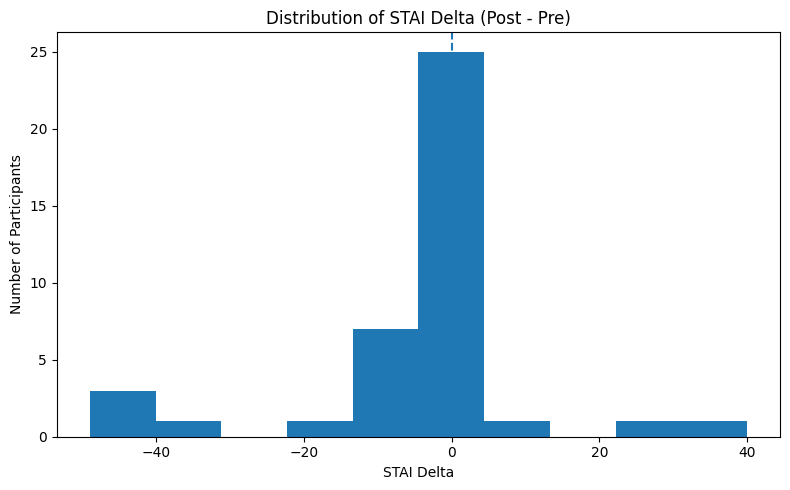

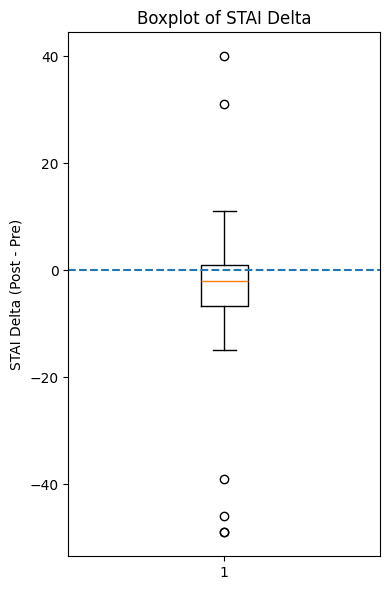

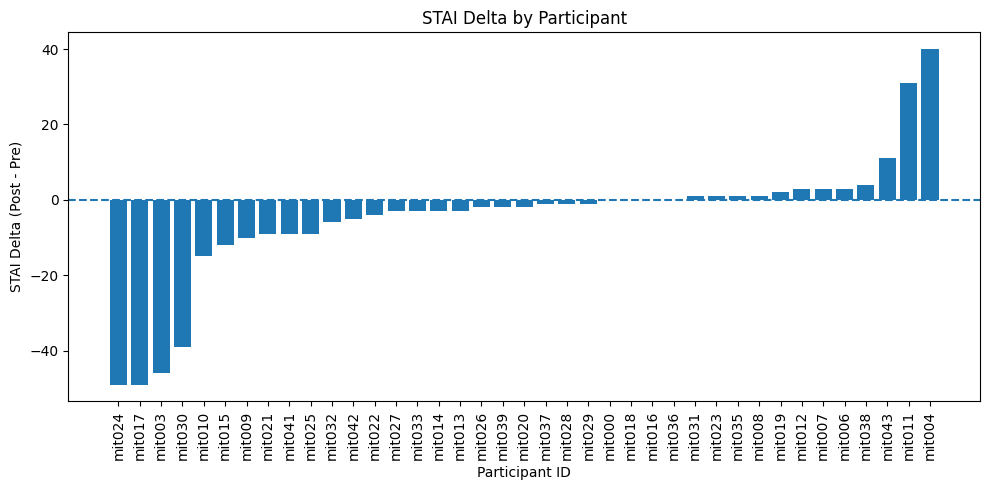

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Load STAI-only CSV
# --------------------------------------------------
stai_path = "/Users/jane/Desktop/ACMMI/Qualtrics/-251123/STAI_only_features.csv"
stai_df = pd.read_csv(stai_path)

# Optional: basic info
print("Loaded STAI shape:", stai_df.shape)
print(stai_df.head())

# Remove rows with missing delta just in case
stai_df = stai_df.dropna(subset=["stai_delta"]).reset_index(drop=True)

# --------------------------------------------------
# 2. Histogram of STAI delta
# --------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(stai_df["stai_delta"], bins=10)
plt.axvline(0, linestyle="--")  # line at 0 (no change)
plt.title("Distribution of STAI Delta (Post - Pre)")
plt.xlabel("STAI Delta")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3. Boxplot of STAI delta
# --------------------------------------------------
plt.figure(figsize=(4, 6))
plt.boxplot(stai_df["stai_delta"], vert=True)
plt.axhline(0, linestyle="--")
plt.title("Boxplot of STAI Delta")
plt.ylabel("STAI Delta (Post - Pre)")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. Bar chart of STAI delta by participant (sorted)
# --------------------------------------------------
# Sort by delta (e.g., from most decrease to most increase)
stai_sorted = stai_df.sort_values("stai_delta").reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.bar(stai_sorted["participant_id"], stai_sorted["stai_delta"])
plt.axhline(0, linestyle="--")
plt.title("STAI Delta by Participant")
plt.xlabel("Participant ID")
plt.ylabel("STAI Delta (Post - Pre)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
